In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)

#tensorflow libraries
import tensorflow as tf
from tensorflow import feature_column as fc
from tensorflow.keras import layers
from tensorflow.keras import models

%matplotlib inline

In [2]:
## Get multiple outputs in the same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Ignore all warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [3]:
## Display all rows and columns of a dataframe instead of a truncated version
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
df_transaction = pd.read_csv('data/cafe_transaction_store.csv')
df_cafesell = pd.read_csv('data/cafe_sell_metadata.csv')
df_dateinfo = pd.read_csv('data/cafe_dateinfo.csv')

# Exploring transaction dataset

Let's look at the basic information of the data.

In [5]:
df_transaction.head()

,CALENDAR_DATE,PRICE,QUANTITY,SELL_ID,SELL_CATEGORY
0,01/01/12,15.50,46,1070,0
1,01/01/12,12.73,22,2051,2
2,01/01/12,12.75,18,2052,2
3,01/01/12,12.60,30,2053,2
4,01/02/12,15.50,70,1070,0


In [6]:
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5404 entries, 0 to 5403
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CALENDAR_DATE  5404 non-null   object 
 1   PRICE          5404 non-null   float64
 2   QUANTITY       5404 non-null   int64  
 3   SELL_ID        5404 non-null   int64  
 4   SELL_CATEGORY  5404 non-null   int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 211.2+ KB


In [7]:
df_transaction.shape

(5404, 5)

Based on the dataset, there are a few things we can observe:
1. The CALENDAR_DATE type is wrong.
2. There are no null values. 
3. SELL_CATEGORY should be categorical.

Now, let's do some plotting to examine what the data looks like.

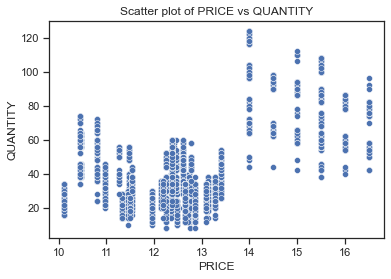

In [100]:
sns.scatterplot(df_transaction['PRICE'], df_transaction['QUANTITY'])
plt.title('Scatter plot of PRICE vs QUANTITY')
plt.show();

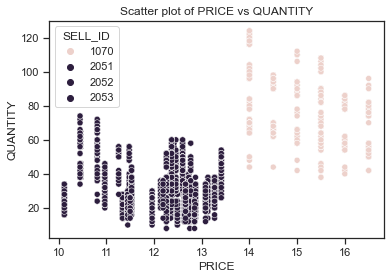

In [99]:
sns.scatterplot(df_transaction['PRICE'], df_transaction['QUANTITY'], hue='SELL_ID', data = df_transaction)
plt.title('Scatter plot of PRICE vs QUANTITY')
plt.show();

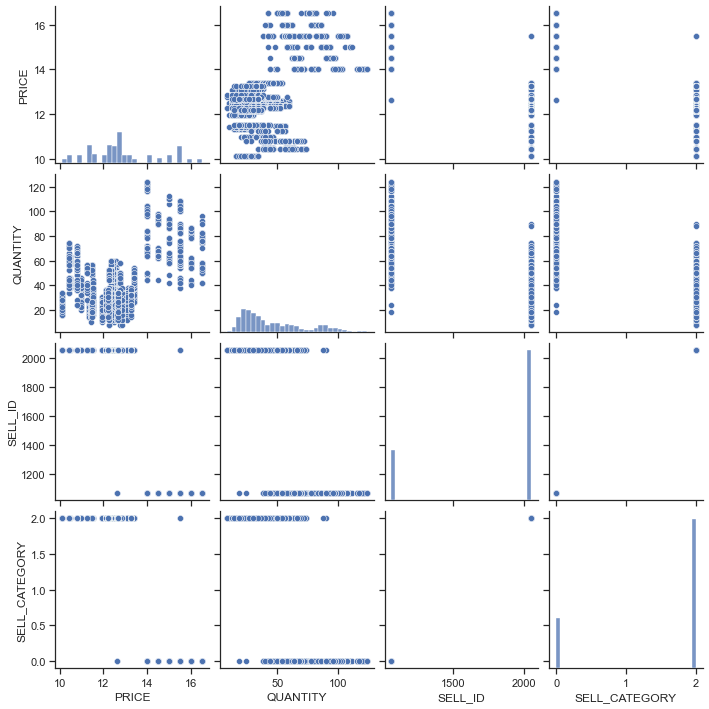

In [8]:
sns.pairplot(df_transaction)

The interesting thing is in the price x quantity scatterplot, we can clearly see that there are at least 2 classes. The data is divided into 2 groups, indicating that this is a *non-linear problem*. Now let's look at the PRICE history by plotting a line chart. For the sake of simplicity, I will group the data by datetime and compute the average price.

In [9]:
df_transaction.CALENDAR_DATE = pd.to_datetime(df_transaction.CALENDAR_DATE)

In [10]:
grouped_transaction = df_transaction.groupby('CALENDAR_DATE')['PRICE'].mean().reset_index()

In [11]:
grouped_transaction.head()

,CALENDAR_DATE,PRICE
0,2012-01-01,13.395
1,2012-01-02,13.395
2,2012-01-03,13.395
3,2012-01-04,13.395
4,2012-01-05,13.395


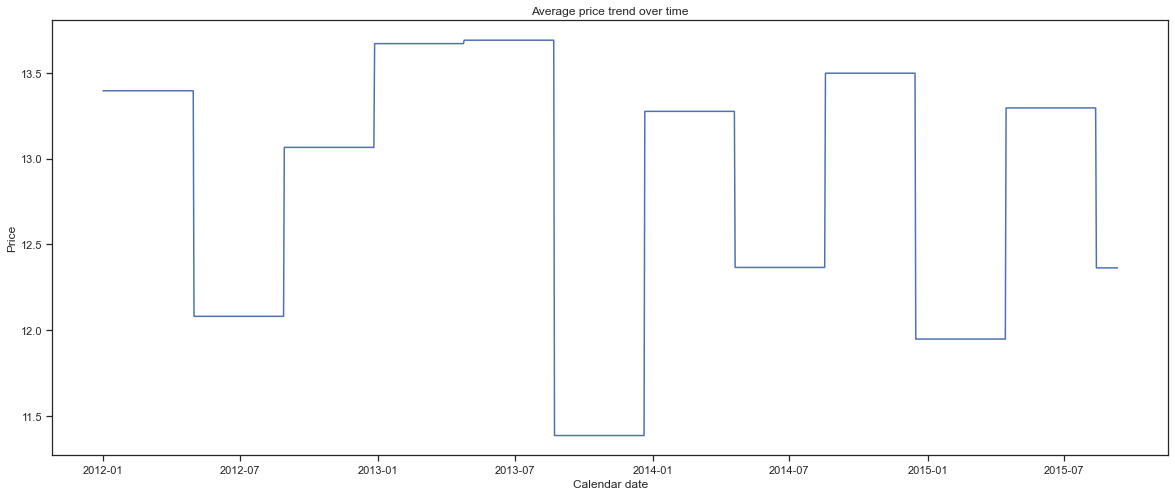

In [12]:
#plotting the transaction
plt.figure(figsize=(20,8))
#plt.plot(grouped_transaction['CALENDAR_DATE'], grouped_transaction['PRICE'])
sns.lineplot(x = 'CALENDAR_DATE', y = 'PRICE', data = grouped_transaction)
plt.xlabel('Calendar date')
plt.ylabel('Price')
plt.title('Average price trend over time')
plt.show();

The average price tend to be cyclical in nature. To make more sense of the data, we should find out whether the SELL_ID plays a part in this. Let's look at the other dataframe.

# Exploring Cafesell Dataset

In [13]:
df_cafesell

,SELL_ID,SELL_CATEGORY,ITEM_ID,ITEM_NAME
0,1070,0,7821,BURGER
1,3055,0,3052,COFFEE
2,3067,0,5030,COKE
3,3028,0,6249,LEMONADE
4,2051,2,7821,BURGER
5,2051,2,5030,COKE
6,2052,2,7821,BURGER
7,2052,2,6249,LEMONADE
8,2053,2,7821,BURGER
9,2053,2,5030,COKE


In [14]:
df_cafesell.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   SELL_ID        11 non-null     int64 
 1   SELL_CATEGORY  11 non-null     int64 
 2   ITEM_ID        11 non-null     int64 
 3   ITEM_NAME      11 non-null     object
dtypes: int64(3), object(1)
memory usage: 480.0+ bytes


In [15]:
df_cafesell.describe()

,SELL_ID,SELL_CATEGORY,ITEM_ID
count,11.000000,11.000000,11.000000
mean,2235.000000,1.272727,5906.909091
std,598.728653,1.009050,1830.217170
min,1070.000000,0.000000,3052.000000
25%,2051.500000,0.000000,5030.000000
50%,2053.000000,2.000000,6249.000000
75%,2540.500000,2.000000,7821.000000
max,3067.000000,2.000000,7821.000000


It seems that tere are two categories only, which is 0 and 2. Let's find out what they are.

In [16]:
grouped_df_cafesell = pd.concat([df_cafesell.SELL_ID, pd.get_dummies(df_cafesell.ITEM_NAME).astype(int)], axis=1).groupby(df_cafesell.SELL_ID).sum()
grouped_df_cafesell.SELL_ID = grouped_df_cafesell.index.tolist()
grouped_df_cafesell.reset_index(drop=True, inplace=True)

In [17]:
grouped_df_cafesell

,SELL_ID,BURGER,COFFEE,COKE,LEMONADE
0,1070,1,0,0,0
1,2051,1,0,1,0
2,2052,1,0,0,1
3,2053,1,1,1,0
4,3028,0,0,0,1
5,3055,0,1,0,0
6,3067,0,0,1,0


Apparently, the SELL_CATEGORY is whether it's an individual puchase of an item or a combo puchase. 

But before joining the tables, let's look at the other dataset.

# Exploring Dateinfo Dataset

In [18]:
df_dateinfo.head()

,CALENDAR_DATE,YEAR,HOLIDAY,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
0,1/1/12,2012,New Year,1,0,24.8,0
1,1/2/12,2012,New Year,0,0,24.8,0
2,1/3/12,2012,New Year,0,0,32.0,1
3,1/4/12,2012,NaN,0,0,32.0,1
4,1/5/12,2012,NaN,0,0,24.8,0


In [19]:
df_dateinfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1349 entries, 0 to 1348
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CALENDAR_DATE        1349 non-null   object 
 1   YEAR                 1349 non-null   int64  
 2   HOLIDAY              105 non-null    object 
 3   IS_WEEKEND           1349 non-null   int64  
 4   IS_SCHOOLBREAK       1349 non-null   int64  
 5   AVERAGE_TEMPERATURE  1349 non-null   float64
 6   IS_OUTDOOR           1349 non-null   int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 73.9+ KB


Key takeaways from this dataset:
1. The CALENDAR_DATE is string, it should be datetime.
2. There are missing values on the HOLIDAY column. We'll impute the column using "No Holiday"
3. AVERAGE_TEMPERATURE is a bit unclear. Is it within the cafe, or the outside temperature?
4. IS_OUTDOOR is also unclear. Since this dataset tells us only about dates and whether or not it's weekend, holiday, and school break, it becomes a bit unclear what IS_OUTDOOR means.

In [20]:
#imputing "No Holiday" to the NaN values
df_dateinfo.HOLIDAY.fillna('No Holiday', inplace = True)

#change CALENDAR_DATE to datetime
df_dateinfo.CALENDAR_DATE = pd.to_datetime(df_dateinfo.CALENDAR_DATE)

In [95]:
df_dateinfo.head()

,CALENDAR_DATE,YEAR,HOLIDAY,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
0,2012-01-01,2012,New Year,1,0,24.8,0
1,2012-01-02,2012,New Year,0,0,24.8,0
2,2012-01-03,2012,New Year,0,0,32.0,1
3,2012-01-04,2012,No Holiday,0,0,32.0,1
4,2012-01-05,2012,No Holiday,0,0,24.8,0


In [21]:
df_dateinfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1349 entries, 0 to 1348
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CALENDAR_DATE        1349 non-null   datetime64[ns]
 1   YEAR                 1349 non-null   int64         
 2   HOLIDAY              1349 non-null   object        
 3   IS_WEEKEND           1349 non-null   int64         
 4   IS_SCHOOLBREAK       1349 non-null   int64         
 5   AVERAGE_TEMPERATURE  1349 non-null   float64       
 6   IS_OUTDOOR           1349 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 73.9+ KB


For sanity checking, we examine the info. Now, there are no null values present in the dataset.

Now, let's look at the holiday column.

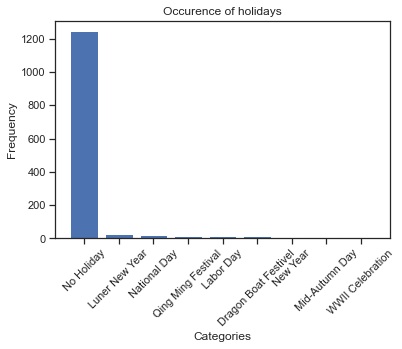

In [22]:
plt.bar(df_dateinfo.HOLIDAY.value_counts().index, df_dateinfo.HOLIDAY.value_counts().values)
plt.xlabel('Categories')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.title('Occurence of holidays')
plt.show();

In [23]:
df_dateinfo.HOLIDAY.value_counts()

HOLIDAY
No Holiday              1244
Luner New Year            28
National Day              21
Qing Ming Festival        12
Labor Day                 12
Dragon Boat Festivel      12
New Year                  10
Mid-Autumn Day             7
WWII Celebration           3
Name: count, dtype: int64

I didn't see any US holidays. Most probably, this cafe is situated somewhere in Asia. Perhaps China, or it could also be Singapore. Still unclear.

# Combining the 3 datasets

Now let's combine all the datasets to look at the price trends and other plots. This will be usefull for us to determine what algorithm we should use to make a price prediction.

In [24]:
df_transaction.head()

,CALENDAR_DATE,PRICE,QUANTITY,SELL_ID,SELL_CATEGORY
0,2012-01-01,15.50,46,1070,0
1,2012-01-01,12.73,22,2051,2
2,2012-01-01,12.75,18,2052,2
3,2012-01-01,12.60,30,2053,2
4,2012-01-02,15.50,70,1070,0


In [25]:
df_cafesell.head()

,SELL_ID,SELL_CATEGORY,ITEM_ID,ITEM_NAME
0,1070,0,7821,BURGER
1,3055,0,3052,COFFEE
2,3067,0,5030,COKE
3,3028,0,6249,LEMONADE
4,2051,2,7821,BURGER


In [26]:
#merging the 2 dataframes on SELL_ID. I won't need the SELL_CATEGORY column in one of the dataset and ITEM_ID in the df_cafesell since I already have the ITEM_NAME
bridging_data = pd.merge(df_cafesell.drop(['ITEM_ID'], axis=1), df_transaction.drop(['SELL_CATEGORY'], axis=1), on='SELL_ID')


In [27]:
bridging_data.head()

,SELL_ID,SELL_CATEGORY,ITEM_NAME,CALENDAR_DATE,PRICE,QUANTITY
0,1070,0,BURGER,2012-01-01,15.5,46
1,1070,0,BURGER,2012-01-02,15.5,70
2,1070,0,BURGER,2012-01-03,15.5,62
3,1070,0,BURGER,2012-01-04,15.5,88
4,1070,0,BURGER,2012-01-05,15.5,104


Now, I will group it by SELL_ID, SELL_CATEGORY, ITEM_NAME, CALENDAR_DATE, and PRICE. Then I'll sum the quantity. This is so that we can look at the price trends in each SELL_ID or even ITEM_NAME better

In [28]:
grouped_bridging_data = bridging_data.groupby(['SELL_ID', 'SELL_CATEGORY', 'ITEM_NAME', 'CALENDAR_DATE','PRICE']).QUANTITY.sum().reset_index()

In [29]:
grouped_bridging_data.head()

,SELL_ID,SELL_CATEGORY,ITEM_NAME,CALENDAR_DATE,PRICE,QUANTITY
0,1070,0,BURGER,2012-01-01,15.5,46
1,1070,0,BURGER,2012-01-02,15.5,70
2,1070,0,BURGER,2012-01-03,15.5,62
3,1070,0,BURGER,2012-01-04,15.5,88
4,1070,0,BURGER,2012-01-05,15.5,104


In [30]:
grouped_bridging_data.SELL_ID.unique()

array([1070, 2051, 2052, 2053], dtype=int64)

In [31]:
grouped_bridging_data.shape

(10792, 6)

In [32]:
grouped_bridging_data[grouped_bridging_data.SELL_ID==2051].head()

,SELL_ID,SELL_CATEGORY,ITEM_NAME,CALENDAR_DATE,PRICE,QUANTITY
1349,2051,2,BURGER,2012-01-01,12.73,22
1350,2051,2,BURGER,2012-01-02,12.73,22
1351,2051,2,BURGER,2012-01-03,12.73,26
1352,2051,2,BURGER,2012-01-04,12.73,26
1353,2051,2,BURGER,2012-01-05,12.73,36


Now, let's merge the other dataset to this.

In [33]:
df_use = pd.merge(grouped_bridging_data, df_dateinfo, on='CALENDAR_DATE')

In [34]:
df_use.head(20)

,SELL_ID,SELL_CATEGORY,ITEM_NAME,CALENDAR_DATE,PRICE,QUANTITY,YEAR,HOLIDAY,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
0,1070,0,BURGER,2012-01-01,15.50,46,2012,New Year,1,0,24.8,0
1,2051,2,BURGER,2012-01-01,12.73,22,2012,New Year,1,0,24.8,0
2,2051,2,COKE,2012-01-01,12.73,22,2012,New Year,1,0,24.8,0
3,2052,2,BURGER,2012-01-01,12.75,18,2012,New Year,1,0,24.8,0
4,2052,2,LEMONADE,2012-01-01,12.75,18,2012,New Year,1,0,24.8,0
5,2053,2,BURGER,2012-01-01,12.60,30,2012,New Year,1,0,24.8,0
6,2053,2,COFFEE,2012-01-01,12.60,30,2012,New Year,1,0,24.8,0
7,2053,2,COKE,2012-01-01,12.60,30,2012,New Year,1,0,24.8,0
8,1070,0,BURGER,2012-01-02,15.50,70,2012,New Year,0,0,24.8,0
9,2051,2,BURGER,2012-01-02,12.73,22,2012,New Year,0,0,24.8,0


In [35]:
df_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10808 entries, 0 to 10807
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   SELL_ID              10808 non-null  int64         
 1   SELL_CATEGORY        10808 non-null  int64         
 2   ITEM_NAME            10808 non-null  object        
 3   CALENDAR_DATE        10808 non-null  datetime64[ns]
 4   PRICE                10808 non-null  float64       
 5   QUANTITY             10808 non-null  int64         
 6   YEAR                 10808 non-null  int64         
 7   HOLIDAY              10808 non-null  object        
 8   IS_WEEKEND           10808 non-null  int64         
 9   IS_SCHOOLBREAK       10808 non-null  int64         
 10  AVERAGE_TEMPERATURE  10808 non-null  float64       
 11  IS_OUTDOOR           10808 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(7), object(2)
memory usage: 1013.4+ KB


The resulting total row is 10808. We're going to use this dataset.

# Exploring the combined dataset

In [36]:
df_use.head()

,SELL_ID,SELL_CATEGORY,ITEM_NAME,CALENDAR_DATE,PRICE,QUANTITY,YEAR,HOLIDAY,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
0,1070,0,BURGER,2012-01-01,15.50,46,2012,New Year,1,0,24.8,0
1,2051,2,BURGER,2012-01-01,12.73,22,2012,New Year,1,0,24.8,0
2,2051,2,COKE,2012-01-01,12.73,22,2012,New Year,1,0,24.8,0
3,2052,2,BURGER,2012-01-01,12.75,18,2012,New Year,1,0,24.8,0
4,2052,2,LEMONADE,2012-01-01,12.75,18,2012,New Year,1,0,24.8,0


1. Is price higher when it's weekend?
2. Is price higher when it's holiday?

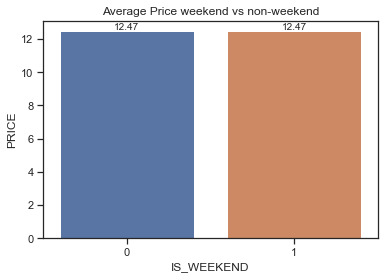

In [37]:
weekend_data = df_use.groupby('IS_WEEKEND').PRICE.mean().reset_index()
sns.barplot(x='IS_WEEKEND', y='PRICE', data=weekend_data)
for index, value in enumerate(weekend_data['PRICE']):
    plt.text(index, value, str(round(value, 2)), ha='center', va='bottom')
plt.title('Average Price weekend vs non-weekend')
plt.show();

In [38]:
weekend_data

,IS_WEEKEND,PRICE
0,0,12.466078
1,1,12.465711


The price seems to be higher when it's not weekend. Let's check the quantity.

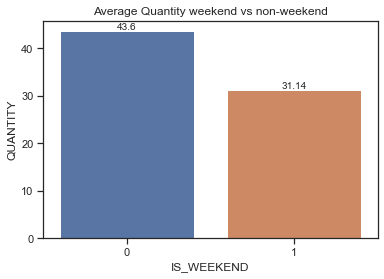

In [39]:
weekend_data = df_use.groupby('IS_WEEKEND').QUANTITY.mean().reset_index()
sns.barplot(x='IS_WEEKEND', y='QUANTITY', data=weekend_data)
for index, value in enumerate(weekend_data['QUANTITY']):
    plt.text(index, value, str(round(value, 2)), ha='center', va='bottom')
plt.title('Average Quantity weekend vs non-weekend')
plt.show();

To conclude, the average price seems to be higher and there are more items sold on average when it's not a weekend. Now, let's examine whether the price and quantity is higher during holidays.

In [40]:
holiday_data = df_use[['HOLIDAY', 'PRICE']]

#create a function to be applied to the dataframe
def map_holidays(holiday):
    if holiday == 'No Holiday':
        return 0
    else:
        return 1
holiday_data['IS_HOLIDAY'] = holiday_data['HOLIDAY'].apply(map_holidays)

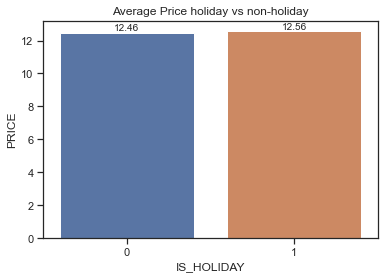

In [41]:
holiday_data_grouped = holiday_data.groupby('IS_HOLIDAY').PRICE.mean().reset_index()
sns.barplot(x='IS_HOLIDAY', y='PRICE', data=holiday_data_grouped)
for index, value in enumerate(holiday_data_grouped['PRICE']):
    plt.text(index, value, str(round(value, 2)), ha='center', va='bottom')
plt.title('Average Price holiday vs non-holiday')
plt.show();

In [42]:
holiday_data_grouped

,IS_HOLIDAY,PRICE
0,0,12.457687
1,1,12.564310


The price is higher during the holidays, although not by much. 

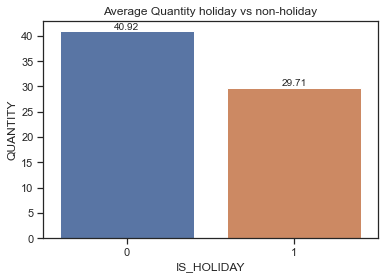

In [43]:
holiday_data = df_use[['HOLIDAY', 'QUANTITY']]
holiday_data['IS_HOLIDAY'] = holiday_data['HOLIDAY'].apply(map_holidays)

holiday_data_grouped = holiday_data.groupby('IS_HOLIDAY').QUANTITY.mean().reset_index()
sns.barplot(x='IS_HOLIDAY', y='QUANTITY', data=holiday_data_grouped)
for index, value in enumerate(holiday_data_grouped['QUANTITY']):
    plt.text(index, value, str(round(value, 2)), ha='center', va='bottom')
plt.title('Average Quantity holiday vs non-holiday')
plt.show();

The number of items sold on average is higher when it's not a holiday compared to when it's a holiday. Now, let's see the price trends.

In [44]:
grouped_transaction = df_use.groupby('CALENDAR_DATE')['PRICE'].mean().reset_index()

In [45]:
grouped_transaction.head()

,CALENDAR_DATE,PRICE
0,2012-01-01,13.0325
1,2012-01-02,13.0325
2,2012-01-03,13.0325
3,2012-01-04,13.0325
4,2012-01-05,13.0325


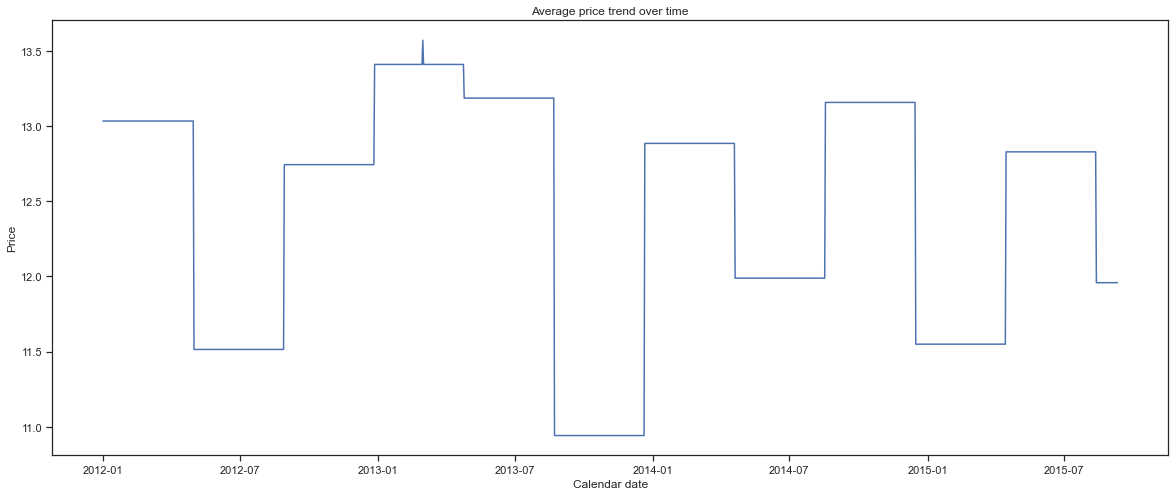

In [46]:
#plotting the transaction
plt.figure(figsize=(20,8))
#plt.plot(grouped_transaction['CALENDAR_DATE'], grouped_transaction['PRICE'])
sns.lineplot(x = 'CALENDAR_DATE', y = 'PRICE', data = grouped_transaction)
plt.xlabel('Calendar date')
plt.ylabel('Price')
plt.title('Average price trend over time')
plt.show();

I'll also check the quantity of items sold.

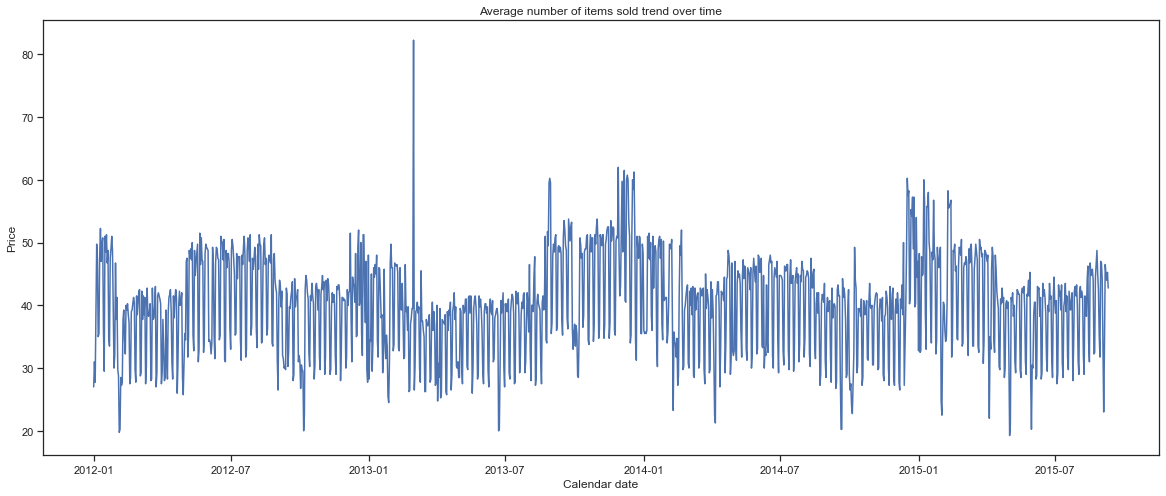

In [47]:
grouped_transaction = df_use.groupby('CALENDAR_DATE')['QUANTITY'].mean().reset_index()

#plotting the transaction
plt.figure(figsize=(20,8))
#plt.plot(grouped_transaction['CALENDAR_DATE'], grouped_transaction['PRICE'])
sns.lineplot(x = 'CALENDAR_DATE', y = 'QUANTITY', data = grouped_transaction)
plt.xlabel('Calendar date')
plt.ylabel('Price')
plt.title('Average number of items sold trend over time')
plt.show();

Both the price and quantity charts show cyclical data. Let's see if a sell of individual burger is also similar to this when graphed. We'll also analyze the price difference when it's weekend and non-weekend, and holiday vs non-holiday.

First, I'll check whether there are data points in the individual sales data, which are SELL_ID of 1070, 3028, 3055, 3067. Then, I'll create 3 plotting functions and use the functions to plot the data for the sake of time.

In [48]:
df_use[df_use['SELL_ID']==1070].shape

(1351, 12)

In [49]:
df_use[df_use['SELL_ID']==3028].shape

(0, 12)

In [50]:
df_use[df_use['SELL_ID']==3055].shape

(0, 12)

In [51]:
df_use[df_use['SELL_ID']==3067].shape

(0, 12)

Apparently, the only one item bought in individual (no combo) is burger. Coke, lemonade, and coffee are not bought by themselves. It's safe to say that this is a burger joint instead of a cafe.

Next, I'll create plotting functions taking account of SELL_ID and ITEM_NAME just in case in the future there are individual purchases of Coke, lemonade, and coffee.

In [52]:
def create_individual_plot(df, sell_id, item_name, price_or_quantity):
    df_use = df.copy()
    df_new = df_use[(df_use['SELL_ID'] == sell_id) & (df_use['ITEM_NAME']==item_name)]
    grouped_transaction = df_new.groupby('CALENDAR_DATE')[price_or_quantity].mean().reset_index()
    #plotting the transaction
    plt.figure(figsize=(20,8))
    #plt.plot(grouped_transaction['CALENDAR_DATE'], grouped_transaction['PRICE'])
    sns.lineplot(x = 'CALENDAR_DATE', y = price_or_quantity, data = df_new)
    plt.xlabel('Calendar date')
    plt.ylabel(price_or_quantity)
    plt.title(f'Average {item_name} {price_or_quantity} trend over time')
    plt.show();

In [53]:
def create_weekend_barchart(df, sell_id, item_name, price_or_quantity):
    df_use = df.copy()
    df_new = df_use[(df_use['SELL_ID'] == sell_id) & (df_use['ITEM_NAME']==item_name)]
    weekend_data = df_new.groupby('IS_WEEKEND')[price_or_quantity].mean().reset_index()
    #plotting
    sns.barplot(x='IS_WEEKEND', y=price_or_quantity, data=weekend_data)
    plt.title(f'Average {item_name} {price_or_quantity} weekend vs non-weekend')
    plt.show();
    print(weekend_data.value_counts())

In [54]:
def create_holiday_barchart(df, sell_id, item_name, price_or_quantity):
    df_use = df.copy()
    df_new = df_use[(df_use['SELL_ID'] == sell_id) & (df_use['ITEM_NAME']==item_name)]
    holiday_data = df_new[['HOLIDAY', price_or_quantity]]
    holiday_data['IS_HOLIDAY'] = holiday_data['HOLIDAY'].apply(map_holidays)
    #plotting
    holiday_data_grouped = holiday_data.groupby('IS_HOLIDAY')[price_or_quantity].mean().reset_index()
    sns.barplot(x='IS_HOLIDAY', y=price_or_quantity, data=holiday_data_grouped)
    plt.title(f'Average {item_name} {price_or_quantity} holiday vs non-holiday')
    plt.show();
    print(holiday_data_grouped.value_counts())

## Examining burger - 1070 data

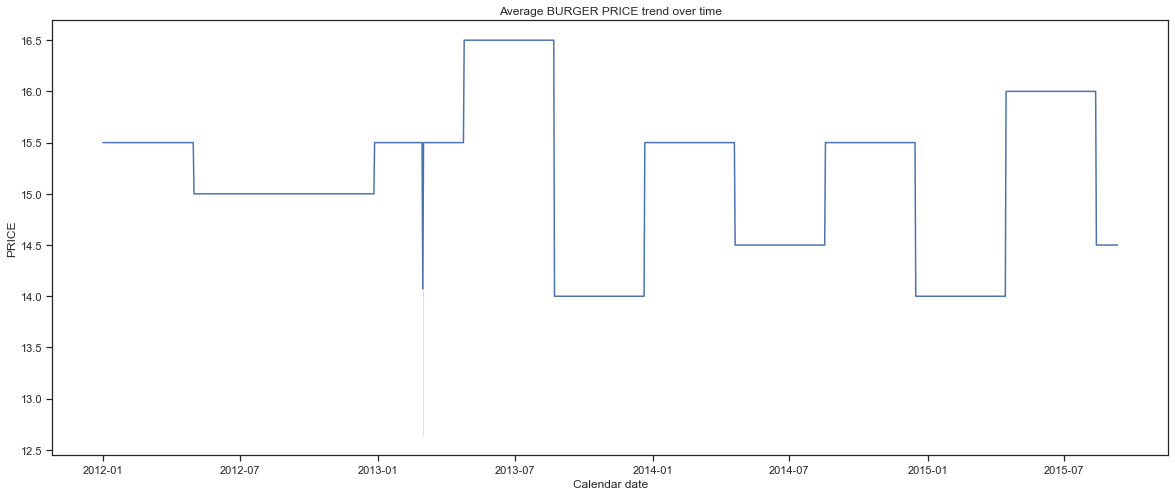

In [55]:
create_individual_plot(df_use, 1070, 'BURGER', 'PRICE')

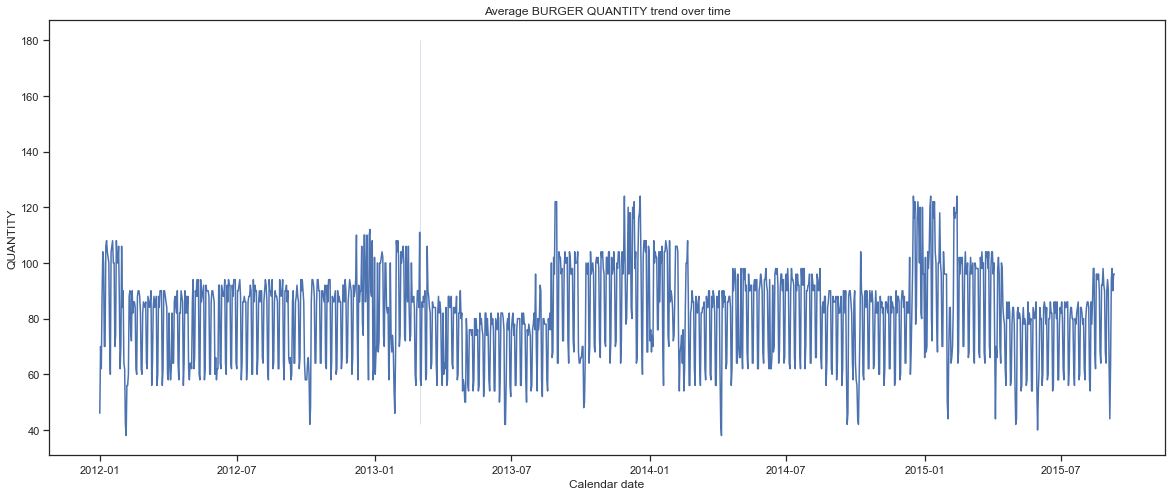

In [56]:
create_individual_plot(df_use, 1070, 'BURGER', 'QUANTITY')

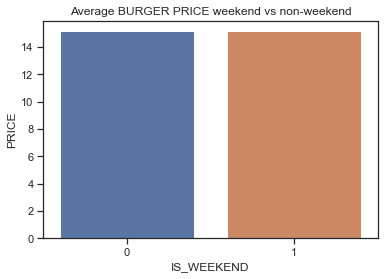

IS_WEEKEND  PRICE    
0           15.161781    1
1           15.167532    1
Name: count, dtype: int64


In [57]:
create_weekend_barchart(df_use, 1070, 'BURGER', 'PRICE')

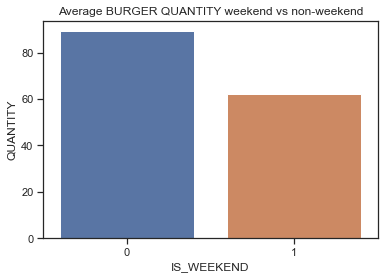

IS_WEEKEND  QUANTITY 
0           89.227743    1
1           62.322078    1
Name: count, dtype: int64


In [58]:
create_weekend_barchart(df_use, 1070, 'BURGER', 'QUANTITY')

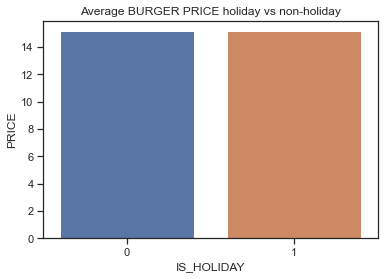

IS_HOLIDAY  PRICE    
0           15.163949    1
1           15.157143    1
Name: count, dtype: int64


In [59]:
create_holiday_barchart(df_use, 1070, 'BURGER', 'PRICE')

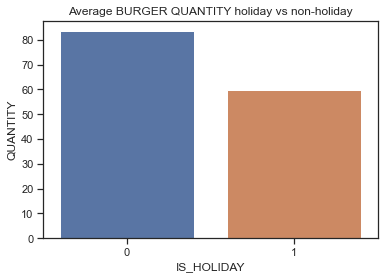

IS_HOLIDAY  QUANTITY 
0           83.409310    1
1           59.619048    1
Name: count, dtype: int64


In [60]:
create_holiday_barchart(df_use, 1070, 'BURGER', 'QUANTITY')

The price and quantity charts still shows that it's a cyclical data. The shape is pretty much similar to the previous line charts, but I can't identify specific time cycle where the price increased or decreased. The price is not much different whether this is on holiday or weekends. The quantity seems to be significantly different. The average number of burgers bought during the weekdays and non-holidays is higher by 20 compared to the weekends and holidays.

Probably, the burger joint is located close to office spaces so it's selling more during the weekdays and non-holiday seasons.

# Takeaways from EDA
I decided to finish the EDA here for the sake of time. Now I will build a machine learning model to make a prediction. There are a few things to note:
1. The relationship between the 2 continuous variables (PRICE and QUANTITY) indicates that this is not a linear problem.
2. To introduce non-linearity to the model, I decided to use simple neural network. Also, this is to brush up my Tensorflow skills.
3. The data is cyclical, so it might be useful to map day of the week and month. 

So, I'll start with the feature engineering.

# Feature Engineering
There are a few things to do:
1. When we looked at the dataset, it's clear that there are 2 different categories of sales. One is individual item sales (which only consists of BURGER), and the other is combo sales. If we look at the grouped_df_cafesell, we'll find what combo each SELL_ID consists of. I'll do that below.

In [61]:
df_use.head()

,SELL_ID,SELL_CATEGORY,ITEM_NAME,CALENDAR_DATE,PRICE,QUANTITY,YEAR,HOLIDAY,IS_WEEKEND,IS_SCHOOLBREAK,AVERAGE_TEMPERATURE,IS_OUTDOOR
0,1070,0,BURGER,2012-01-01,15.50,46,2012,New Year,1,0,24.8,0
1,2051,2,BURGER,2012-01-01,12.73,22,2012,New Year,1,0,24.8,0
2,2051,2,COKE,2012-01-01,12.73,22,2012,New Year,1,0,24.8,0
3,2052,2,BURGER,2012-01-01,12.75,18,2012,New Year,1,0,24.8,0
4,2052,2,LEMONADE,2012-01-01,12.75,18,2012,New Year,1,0,24.8,0


In [62]:
grouped_df_cafesell

,SELL_ID,BURGER,COFFEE,COKE,LEMONADE
0,1070,1,0,0,0
1,2051,1,0,1,0
2,2052,1,0,0,1
3,2053,1,1,1,0
4,3028,0,0,0,1
5,3055,0,1,0,0
6,3067,0,0,1,0


2. If we look at the df_use, we'll see that on the 2nd and 3rd row, the SELL_ID is the same. The ITEM_NAME is different. The PRICE is the same. This is actually a combo sale, consisting of BURGER and COKE. When we look at the next 2 rows (BURGER and LEMONADE), it's also clear that those are combo sales as well. So, the first feature engineering (although it's more like data cleaning) is to combine the 2 names into one.

In [63]:
def join_item_names(item_names):
    return ' - '.join(set(item_names))

In [64]:
df_model = df_use.groupby(['SELL_ID', 'CALENDAR_DATE']).agg({
    'ITEM_NAME': join_item_names,
    'PRICE': 'first',
    'QUANTITY': 'first',
    'HOLIDAY':'first',
    'IS_WEEKEND':'first',
    'IS_SCHOOLBREAK':'first'    
}).reset_index().drop('SELL_ID', axis=1)

The resulting dataframe is like this

In [102]:
df_model.head(5)

,CALENDAR_DATE,ITEM_NAME,PRICE,QUANTITY,HOLIDAY,IS_WEEKEND,IS_SCHOOLBREAK
0,2012-01-01,BURGER,15.5,46,New Year,1,0
1,2012-01-02,BURGER,15.5,70,New Year,0,0
2,2012-01-03,BURGER,15.5,62,New Year,0,0
3,2012-01-04,BURGER,15.5,88,No Holiday,0,0
4,2012-01-05,BURGER,15.5,104,No Holiday,0,0


In [103]:
df_model.tail(5)

,CALENDAR_DATE,ITEM_NAME,PRICE,QUANTITY,HOLIDAY,IS_WEEKEND,IS_SCHOOLBREAK
5387,2015-09-06,COFFEE - COKE - BURGER,11.26,54,No Holiday,1,0
5388,2015-09-07,COFFEE - COKE - BURGER,11.26,50,No Holiday,0,0
5389,2015-09-08,COFFEE - COKE - BURGER,11.26,50,No Holiday,0,0
5390,2015-09-09,COFFEE - COKE - BURGER,11.26,54,No Holiday,0,0
5391,2015-09-10,COFFEE - COKE - BURGER,11.26,50,No Holiday,0,0


In [120]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5392 entries, 0 to 5391
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   CALENDAR_DATE   5392 non-null   datetime64[ns]
 1   ITEM_NAME       5392 non-null   object        
 2   PRICE           5392 non-null   float64       
 3   QUANTITY        5392 non-null   int64         
 4   HOLIDAY         5392 non-null   object        
 5   IS_WEEKEND      5392 non-null   int64         
 6   IS_SCHOOLBREAK  5392 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 295.0+ KB


In [121]:
df_model.shape

(5392, 7)

Before we move on, let's create a plot for price and quantity trend line to confirm that all products have price and quantity with cyclical nature.

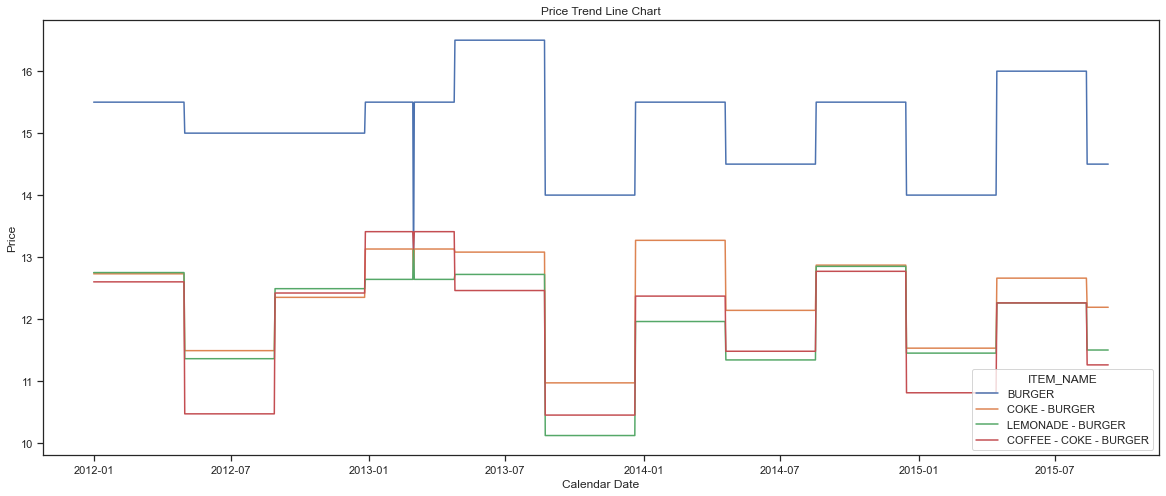

In [109]:
plt.figure(figsize=(20,8))
sns.lineplot(x='CALENDAR_DATE', y='PRICE', hue='ITEM_NAME', data=df_model)
plt.title('Price Trend Line Chart')
plt.xlabel('Calendar Date')
plt.ylabel('Price')

plt.show();

The price seems to be cyclical. I'll plot the quantity

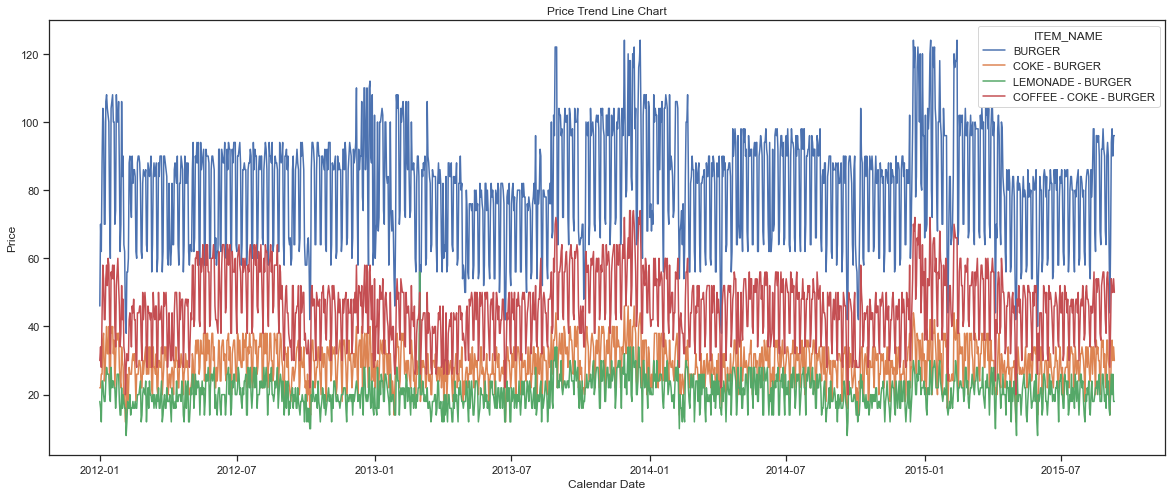

In [110]:
plt.figure(figsize=(20,8))
sns.lineplot(x='CALENDAR_DATE', y='QUANTITY', hue='ITEM_NAME', data=df_model)
plt.title('Price Trend Line Chart')
plt.xlabel('Calendar Date')
plt.ylabel('Price')

plt.show();

The plot is a bit messy. Let's smoothen it so that the cyclical nature is identified more easily.

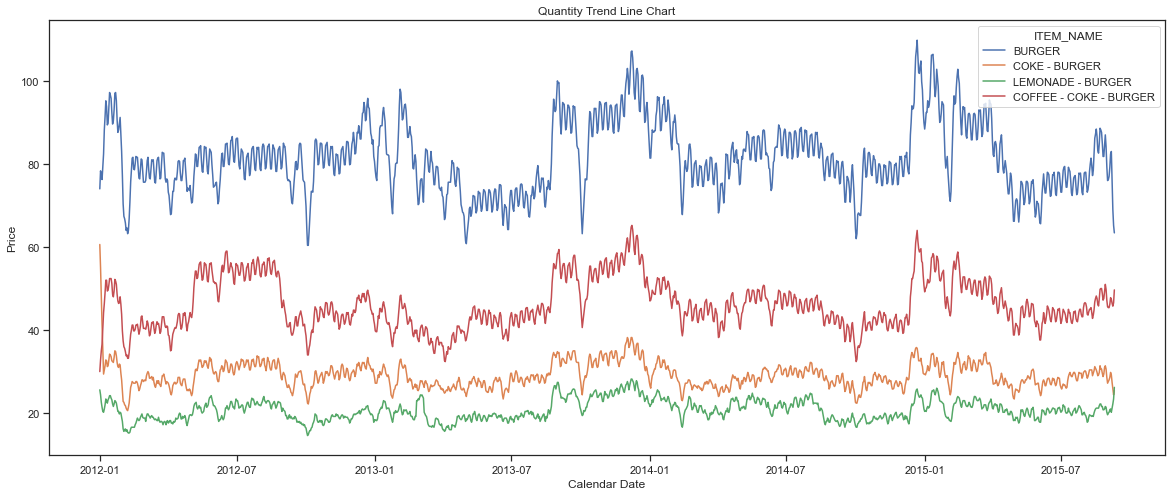

In [119]:
df_plot = df_model.copy()
df_plot['smoothed_QUANTITY'] = df_plot['QUANTITY'].rolling(window=10, min_periods=1, center=True).mean()

plt.figure(figsize=(20,8))
sns.lineplot(x='CALENDAR_DATE', y='smoothed_QUANTITY', hue='ITEM_NAME', data=df_plot)
plt.title('Quantity Trend Line Chart')
plt.xlabel('Calendar Date')
plt.ylabel('Price')

plt.show();

Now we can confirm that both price and quantity for each item is cyclical in nature. This justifies the need to get time-based columns for prediction like the month and day of week.

3. Since this is a cyclical dataset, I will get month and day of week. I will do this when I transform the dataframe into a tensorflow dataset.

# Basic model
Next, I will start to create the model. Again, this is a baseline model with minimal feature engineering. I'm going to do the following:
1. Split the dataframe into train, test, and validation dataframe
2. Create a function to convert the dataframe into tensorflow dataset
3. Perform feature engineering using FeatureSpace
4. Create a simple neural network using 1 hidden dense layer
5. Test the model against the test dataframe
6. Create a simple prediction where the model predicts a given dictionary

In [66]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.utils import FeatureSpace

from tensorflow import feature_column as fc
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

import random
random.seed(42)

In [67]:
#splitting the dataframe
train, test = train_test_split(df_model, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

3450 train examples
863 validation examples
1079 test examples


Next, I will create a df to dataset function to convert pandas dataframe to tensorflow dataset. In the process, I will also create a month and date column from CALENDAR_DATE and drop CALENDAR_DATE column since predicting the data daily based on an exact date might make the model difficult to generalize new data. 

I will also drop the IS_WEEKEND column because it gives the same information as DAY.

Then, I will use the function to convert the training and validation dataframe to dataset.

In [68]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('QUANTITY')
    
    #extracting month and day from the CALENDAR_DATE then dropping the CALENDAR_DATE and IS_WEEKEND column
    #IS_WEEKEND is dropped because it gives the same information as DAY
    dataframe['MONTH'] = dataframe['CALENDAR_DATE'].dt.month
    dataframe['DAY'] = dataframe['CALENDAR_DATE'].dt.strftime('%A') #let's use string just to make it different from month
    dataframe.drop(['CALENDAR_DATE', 'IS_WEEKEND'], axis=1, inplace=True) 
    
    #converting the int in the dataframe to float for processing with feature space
    dataframe['IS_SCHOOLBREAK'] = dataframe['IS_SCHOOLBREAK'].astype('float')
    dataframe['PRICE'] = dataframe['PRICE'].astype('float')
    
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [69]:
#convert dataframe to dataset
batch_size = 32
train_ds = df_to_dataset(train)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)

For sanity checking, let's print the features and the values.

In [70]:
for feature_batch, label_batch in train_ds.take(1):
    print('Every feature:', list(feature_batch.keys()))
    print('A batch of item_name:', feature_batch['ITEM_NAME'])
    print('A batch of quantity:', feature_batch['PRICE'])
    print('A batch of holiday:', feature_batch['HOLIDAY'])
    print('A batch of is_schoolbreak:', feature_batch['IS_SCHOOLBREAK'])
    print('A batch of month:', feature_batch['MONTH'])
    print('A batch of day:', feature_batch['DAY'])
    print('A batch of targets:', label_batch)

Every feature: ['ITEM_NAME', 'PRICE', 'HOLIDAY', 'IS_SCHOOLBREAK', 'MONTH', 'DAY']
A batch of item_name: tf.Tensor(
[b'COKE - BURGER' b'LEMONADE - BURGER' b'LEMONADE - BURGER'
 b'COFFEE - COKE - BURGER' b'COFFEE - COKE - BURGER'
 b'COFFEE - COKE - BURGER' b'COKE - BURGER' b'LEMONADE - BURGER'
 b'COFFEE - COKE - BURGER' b'COFFEE - COKE - BURGER' b'BURGER'
 b'LEMONADE - BURGER' b'COKE - BURGER' b'BURGER' b'LEMONADE - BURGER'
 b'COKE - BURGER' b'LEMONADE - BURGER' b'COKE - BURGER' b'COKE - BURGER'
 b'COFFEE - COKE - BURGER' b'LEMONADE - BURGER' b'COKE - BURGER' b'BURGER'
 b'LEMONADE - BURGER' b'BURGER' b'BURGER' b'LEMONADE - BURGER'
 b'COKE - BURGER' b'LEMONADE - BURGER' b'LEMONADE - BURGER'
 b'COFFEE - COKE - BURGER' b'COFFEE - COKE - BURGER'], shape=(32,), dtype=string)
A batch of quantity: tf.Tensor(
[10.97 11.36 11.45 10.45 10.81 10.47 12.14 12.85 12.26 12.42 15.   11.34
 13.13 15.5  12.75 10.97 11.36 13.08 12.14 12.77 10.12 11.53 16.   12.72
 15.5  16.5  11.96 12.35 10.12 12.26 12.46

Usually, I go with tf.feature_column. But apparently now it's deprecated and the documentation suggests that I use FeatureSpace instead (I guess this shows how I've been playing around with PyTorch and neglected TensorFlow a bit).

FeatureSpace is neat! It's easy and very intuitive to use.

In [71]:
feature_space = FeatureSpace(
    features={
        "PRICE": "float_normalized",
        "ITEM_NAME": "string_categorical",
        "HOLIDAY": "string_categorical",
        "IS_SCHOOLBREAK": "float",
        "MONTH": "integer_categorical",
        "DAY": "string_categorical",
    },
    output_mode="concat",
)

#needs to adapt the feature_space. Reminder: feature_space needs to be adapted to a dataset WITHOUT LABEL
train_ds_with_no_labels = train_ds.map(lambda x, _: x)
feature_space.adapt(train_ds_with_no_labels)

In [72]:
#checking the dataset shape
for x, _ in train_ds.take(1):
    preprocessed_x = feature_space(x)
    print("preprocessed_x.shape:", preprocessed_x.shape)
    print("preprocessed_x.dtype:", preprocessed_x.dtype)

preprocessed_x.shape: (32, 38)
preprocessed_x.dtype: <dtype: 'float32'>


Besides the built-in metrics, I will create a function to calculate RMSE (Root Mean Squared Error) to evaluate the model. This is more interpretable since the measurement unit of the QUANTITY will be the same (unit instead of unit squared).

In [73]:
def rmse(y_true, y_pred):  # Root mean square error
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

In [74]:
#remapping to label
preprocessed_train_ds = train_ds.map(
    lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
preprocessed_train_ds = preprocessed_train_ds.prefetch(tf.data.AUTOTUNE)

#To make sure the training data is read infinitely
preprocessed_train_ds = preprocessed_train_ds.repeat()

preprocessed_val_ds = val_ds.map(
    lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
preprocessed_val_ds = preprocessed_val_ds.prefetch(tf.data.AUTOTUNE)

Now that the datasets are preprocessed, it's time to build the model and train it. I'm going to build 2 models, the training model and the inference model. This is because the training model uses the encoded features as inputs, whereas I would like to make predictions using dictionary as inputs. Therefore, I also created the inference model.

The inference model uses dictionary as inputs and outputs predictions. The training will be done using the training_model. It will adapt the weight accordingly. The weights will then be used by the inference model to make predictions. 

In [75]:
dict_inputs = feature_space.get_inputs()
encoded_features = feature_space.get_encoded_features()
x = keras.layers.Dense(32, activation="relu")(encoded_features)
x = keras.layers.Dropout(0.5)(x) #using dropout layer to avoid overfitting
predictions = keras.layers.Dense(1, activation="linear")(x)

#1st model: training_model
training_model = keras.Model(inputs=encoded_features, outputs=predictions)
training_model.compile(
    optimizer="adam", loss="mse", metrics=[rmse, "mse"]
)

#2nd model: inference_model
inference_model = keras.Model(inputs=dict_inputs, outputs=predictions)

In [76]:
TRAIN_BATCH_SIZE = 32 
NUM_TRAIN_EXAMPLES = 59621 * 5
NUM_EVALS = 40
NUM_EVAL_EXAMPLES = 14906

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)
#early stopping to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [77]:
#training the model
history = training_model.fit(preprocessed_train_ds,
                    validation_data=preprocessed_val_ds,
                    epochs=NUM_EVALS,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[early_stopping])

Epoch 1/40
232/232 [==============================] - 1s 2ms/step - loss: 2125.0444 - rmse: 45.7130 - mse: 2125.0444 - val_loss: 1454.3643 - val_rmse: 37.8579 - val_mse: 1454.3643
Epoch 2/40
232/232 [==============================] - 0s 1ms/step - loss: 886.6993 - rmse: 29.0294 - mse: 886.6993 - val_loss: 469.5479 - val_rmse: 21.3528 - val_mse: 469.5479
Epoch 3/40
232/232 [==============================] - 0s 1ms/step - loss: 401.0351 - rmse: 19.7012 - mse: 401.0351 - val_loss: 252.8785 - val_rmse: 15.6545 - val_mse: 252.8785
Epoch 4/40
232/232 [==============================] - 0s 1ms/step - loss: 291.2176 - rmse: 16.8578 - mse: 291.2176 - val_loss: 181.8170 - val_rmse: 13.2653 - val_mse: 181.8170
Epoch 5/40
232/232 [==============================] - 0s 1ms/step - loss: 251.3485 - rmse: 15.6349 - mse: 251.3485 - val_loss: 146.8027 - val_rmse: 11.9234 - val_mse: 146.8027
Epoch 6/40
232/232 [==============================] - 0s 1ms/step - loss: 225.6784 - rmse: 14.8409 - mse: 225.6784 -

In [78]:
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):  
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history['val_{}'.format(key)])
        plt.title('model {}'.format(key))
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper right');    

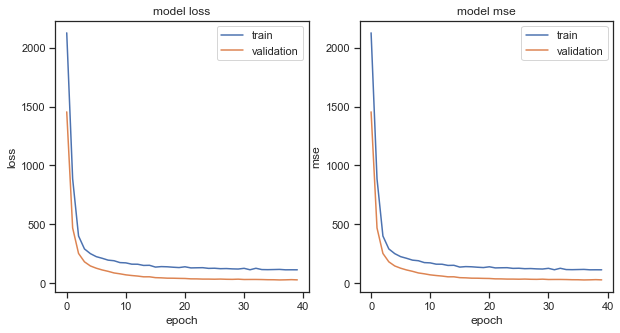

In [79]:
plot_curves(history, ['loss', 'mse'])

I don't see any overfitting problem on the 2 graphs above. I think it's safe to use this model to predict. But first, I will evaluate the test dataset.

## Evaluating the test dataset

To evaluate the dataset, I need to create the same columns as the training dataset.

In [80]:
test['MONTH'] = test['CALENDAR_DATE'].dt.month
test['DAY'] = test['CALENDAR_DATE'].dt.strftime('%A') #let's use string just to make it different from month
test.drop(['CALENDAR_DATE', 'IS_WEEKEND'], axis=1, inplace=True) 

#converting the int in the dataframe to float for processing with feature space
test['IS_SCHOOLBREAK'] = test['IS_SCHOOLBREAK'].astype('float')
test['PRICE'] = test['PRICE'].astype('float')

Next, I will convert the dataframe to dictionary, so that I can use the inference_model to create predictions based on the columns.

In [81]:
#dropping quantity from the dataframe, converting it to list first to append later to the test dataframe
list_quantity = test['QUANTITY'].tolist()
test.drop('QUANTITY', axis=1, inplace=True)
list_of_dicts = [row.to_dict() for _, row in test.iterrows()]

In [82]:
predicted_quantity = []
for i in list_of_dicts:
    #convert the value of the dictionary to tensor
    input_dict = {name: tf.convert_to_tensor([value]) for name, value in i.items()}
    predictions = inference_model.predict(input_dict)
    predicted_quantity.append(predictions[0][0])

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


Next, I will compute the RMSE for the quantity and predicted quantity using sklearn.

In [83]:
from sklearn.metrics import mean_squared_error

#appending the quantity and predicted quantity to the dataframe
test['QUANTITY'] = list_quantity
test['PREDICTED_QUANTITY'] = np.round(predicted_quantity)
rmse = np.sqrt(mean_squared_error(test['QUANTITY'], test['PREDICTED_QUANTITY']))

print('The resulting RMSE for the test dataset is: ', rmse)

5.191334477838722


The RMSE seems to be quite low, so it's safe to say that the model is quite good for predicting new data.

Now for the incoming data, should I want to create a WebApp to make prediction, will be converted into a dictionary. Usually, I will make a JSON file from the input, and convert the JSON file to dictionary.

For this project, I will not make a WebApp. But I will show how the model will predict incoming data from dictionary. Remember, the model used here is the inference_model since the input is in dictionary form. 

Let's look at this example.

In [84]:
#creating a sample data
sample = {
    "ITEM_NAME":tf.convert_to_tensor(['BURGER - COKE']),
    "PRICE":tf.convert_to_tensor([11.5]),
    "HOLIDAY":tf.convert_to_tensor(['No Holiday']),
    "IS_SCHOOLBREAK":tf.convert_to_tensor([1.]),
    "MONTH":tf.convert_to_tensor([12]),
    "DAY":tf.convert_to_tensor(['Tuesday']),
}

In [85]:
#using inference model to predict the sample. 
#I round this result because the resulting quantity should not have decimal values
predictions = inference_model.predict(sample)
print(round(predictions[0][0]))

1/1 [==============================] - 0s 17ms/step
61


With this model, we can make a prediction for how many items will be sold in a certain month on a certain day when there's a holiday or not, and given the price. This is useful to make a price elasticity model. This is the example use case.

In this scenario, the burger joint wants to predict the BURGER quantity they will sell in the month of June and on a Tuesday when there's no holiday and no school break.

So, the burger joint will create suitable variables for this model, except for the price. The price is going to be a list of possible prices. With this, they can:
1. Predict which price gives best quantity.
2. If they know the cost of making a single burger, they can project their profitability. They will use the price where the profit gained is the greatest.

Below is the example from the scenario:

In [86]:
item_name = 'BURGER'
holiday = 'No Holiday'
is_schoolbreak = 0.
month = 6
day = 'Tuesday'

#create a range of price points
min_price = df_use[df_use['ITEM_NAME'] == 'BURGER'].PRICE.min()
max_price = df_use[df_use['ITEM_NAME'] == 'BURGER'].PRICE.max() + 10 #the +10 here is just to see whether the given price can be further increased or not
price = np.arange(min_price, max_price, 0.01)

pred_dict = {}
pred_dict['price'] = price

In [87]:
#using the model to create predictions
predicted_quantity = []
count = 0
for i in price:
    print(f'iteration {count}')
    sample = {
        "ITEM_NAME":tf.convert_to_tensor([item_name]),
        "PRICE":tf.convert_to_tensor([i]),
        "HOLIDAY":tf.convert_to_tensor([holiday]),
        "IS_SCHOOLBREAK":tf.convert_to_tensor([is_schoolbreak]),
        "MONTH":tf.convert_to_tensor([month]),
        "DAY":tf.convert_to_tensor(['day']),
    }
    predictions = inference_model.predict(sample)
    predicted_quantity.append(round(predictions[0][0]))
    count+=1

pred_dict['quantity'] = predicted_quantity
df_pred = pd.DataFrame.from_dict(pred_dict)

iteration 0
1/1 [==============================] - 0s 122ms/step
iteration 1
1/1 [==============================] - 0s 18ms/step
iteration 2
1/1 [==============================] - 0s 17ms/step
iteration 3
1/1 [==============================] - 0s 17ms/step
iteration 4
1/1 [==============================] - 0s 16ms/step
iteration 5
1/1 [==============================] - 0s 19ms/step
iteration 6
1/1 [==============================] - 0s 18ms/step
iteration 7
1/1 [==============================] - 0s 17ms/step
iteration 8
1/1 [==============================] - 0s 17ms/step
iteration 9
1/1 [==============================] - 0s 18ms/step
iteration 10
1/1 [==============================] - 0s 17ms/step
iteration 11
1/1 [==============================] - 0s 17ms/step
iteration 12
1/1 [==============================] - 0s 17ms/step
iteration 13
1/1 [==============================] - 0s 16ms/step
iteration 14
1/1 [==============================] - 0s 17ms/step
iteration 15
1/1 [================

1/1 [==============================] - 0s 18ms/step
iteration 126
1/1 [==============================] - 0s 16ms/step
iteration 127
1/1 [==============================] - 0s 16ms/step
iteration 128
1/1 [==============================] - 0s 16ms/step
iteration 129
1/1 [==============================] - 0s 17ms/step
iteration 130
1/1 [==============================] - 0s 16ms/step
iteration 131
1/1 [==============================] - 0s 17ms/step
iteration 132
1/1 [==============================] - 0s 17ms/step
iteration 133
1/1 [==============================] - 0s 17ms/step
iteration 134
1/1 [==============================] - 0s 17ms/step
iteration 135
1/1 [==============================] - 0s 19ms/step
iteration 136
1/1 [==============================] - 0s 16ms/step
iteration 137
1/1 [==============================] - 0s 17ms/step
iteration 138
1/1 [==============================] - 0s 16ms/step
iteration 139
1/1 [==============================] - 0s 16ms/step
iteration 140
1/1 [=====

1/1 [==============================] - 0s 17ms/step
iteration 250
1/1 [==============================] - 0s 29ms/step
iteration 251
1/1 [==============================] - 0s 15ms/step
iteration 252
1/1 [==============================] - 0s 17ms/step
iteration 253
1/1 [==============================] - 0s 17ms/step
iteration 254
1/1 [==============================] - 0s 16ms/step
iteration 255
1/1 [==============================] - 0s 16ms/step
iteration 256
1/1 [==============================] - 0s 17ms/step
iteration 257
1/1 [==============================] - 0s 17ms/step
iteration 258
1/1 [==============================] - 0s 16ms/step
iteration 259
1/1 [==============================] - 0s 17ms/step
iteration 260
1/1 [==============================] - 0s 17ms/step
iteration 261
1/1 [==============================] - 0s 16ms/step
iteration 262
1/1 [==============================] - 0s 16ms/step
iteration 263
1/1 [==============================] - 0s 16ms/step
iteration 264
1/1 [=====

1/1 [==============================] - 0s 16ms/step
iteration 374
1/1 [==============================] - 0s 17ms/step
iteration 375
1/1 [==============================] - 0s 15ms/step
iteration 376
1/1 [==============================] - 0s 16ms/step
iteration 377
1/1 [==============================] - 0s 16ms/step
iteration 378
1/1 [==============================] - 0s 16ms/step
iteration 379
1/1 [==============================] - 0s 17ms/step
iteration 380
1/1 [==============================] - 0s 17ms/step
iteration 381
1/1 [==============================] - 0s 17ms/step
iteration 382
1/1 [==============================] - 0s 16ms/step
iteration 383
1/1 [==============================] - 0s 22ms/step
iteration 384
1/1 [==============================] - 0s 18ms/step
iteration 385
1/1 [==============================] - 0s 17ms/step
iteration 386
1/1 [==============================] - 0s 16ms/step
iteration 387
1/1 [==============================] - 0s 16ms/step
iteration 388
1/1 [=====

1/1 [==============================] - 0s 17ms/step
iteration 498
1/1 [==============================] - 0s 25ms/step
iteration 499
1/1 [==============================] - 0s 17ms/step
iteration 500
1/1 [==============================] - 0s 18ms/step
iteration 501
1/1 [==============================] - 0s 18ms/step
iteration 502
1/1 [==============================] - 0s 17ms/step
iteration 503
1/1 [==============================] - 0s 17ms/step
iteration 504
1/1 [==============================] - 0s 16ms/step
iteration 505
1/1 [==============================] - 0s 18ms/step
iteration 506
1/1 [==============================] - 0s 16ms/step
iteration 507
1/1 [==============================] - 0s 17ms/step
iteration 508
1/1 [==============================] - 0s 17ms/step
iteration 509
1/1 [==============================] - 0s 19ms/step
iteration 510
1/1 [==============================] - 0s 17ms/step
iteration 511
1/1 [==============================] - 0s 18ms/step
iteration 512
1/1 [=====

1/1 [==============================] - 0s 17ms/step
iteration 622
1/1 [==============================] - 0s 17ms/step
iteration 623
1/1 [==============================] - 0s 17ms/step
iteration 624
1/1 [==============================] - 0s 15ms/step
iteration 625
1/1 [==============================] - 0s 17ms/step
iteration 626
1/1 [==============================] - 0s 18ms/step
iteration 627
1/1 [==============================] - 0s 17ms/step
iteration 628
1/1 [==============================] - 0s 22ms/step
iteration 629
1/1 [==============================] - 0s 18ms/step
iteration 630
1/1 [==============================] - 0s 18ms/step
iteration 631
1/1 [==============================] - 0s 15ms/step
iteration 632
1/1 [==============================] - 0s 17ms/step
iteration 633
1/1 [==============================] - 0s 17ms/step
iteration 634
1/1 [==============================] - 0s 16ms/step
iteration 635
1/1 [==============================] - 0s 16ms/step
iteration 636
1/1 [=====

1/1 [==============================] - 0s 19ms/step
iteration 746
1/1 [==============================] - 0s 17ms/step
iteration 747
1/1 [==============================] - 0s 17ms/step
iteration 748
1/1 [==============================] - 0s 16ms/step
iteration 749
1/1 [==============================] - 0s 21ms/step
iteration 750
1/1 [==============================] - 0s 16ms/step
iteration 751
1/1 [==============================] - 0s 16ms/step
iteration 752
1/1 [==============================] - 0s 16ms/step
iteration 753
1/1 [==============================] - 0s 17ms/step
iteration 754
1/1 [==============================] - 0s 17ms/step
iteration 755
1/1 [==============================] - 0s 17ms/step
iteration 756
1/1 [==============================] - 0s 16ms/step
iteration 757
1/1 [==============================] - 0s 16ms/step
iteration 758
1/1 [==============================] - 0s 17ms/step
iteration 759
1/1 [==============================] - 0s 17ms/step
iteration 760
1/1 [=====

1/1 [==============================] - 0s 17ms/step
iteration 870
1/1 [==============================] - 0s 16ms/step
iteration 871
1/1 [==============================] - 0s 17ms/step
iteration 872
1/1 [==============================] - 0s 18ms/step
iteration 873
1/1 [==============================] - 0s 20ms/step
iteration 874
1/1 [==============================] - 0s 19ms/step
iteration 875
1/1 [==============================] - 0s 19ms/step
iteration 876
1/1 [==============================] - 0s 17ms/step
iteration 877
1/1 [==============================] - 0s 18ms/step
iteration 878
1/1 [==============================] - 0s 17ms/step
iteration 879
1/1 [==============================] - 0s 19ms/step
iteration 880
1/1 [==============================] - 0s 20ms/step
iteration 881
1/1 [==============================] - 0s 19ms/step
iteration 882
1/1 [==============================] - 0s 18ms/step
iteration 883
1/1 [==============================] - 0s 19ms/step
iteration 884
1/1 [=====

1/1 [==============================] - 0s 18ms/step
iteration 994
1/1 [==============================] - 0s 17ms/step
iteration 995
1/1 [==============================] - 0s 16ms/step
iteration 996
1/1 [==============================] - 0s 16ms/step
iteration 997
1/1 [==============================] - 0s 17ms/step
iteration 998
1/1 [==============================] - 0s 16ms/step
iteration 999
1/1 [==============================] - 0s 17ms/step
iteration 1000
1/1 [==============================] - 0s 17ms/step
iteration 1001
1/1 [==============================] - 0s 19ms/step
iteration 1002
1/1 [==============================] - 0s 16ms/step
iteration 1003
1/1 [==============================] - 0s 17ms/step
iteration 1004
1/1 [==============================] - 0s 17ms/step
iteration 1005
1/1 [==============================] - 0s 17ms/step
iteration 1006
1/1 [==============================] - 0s 16ms/step
iteration 1007
1/1 [==============================] - 0s 17ms/step
iteration 1008
1

1/1 [==============================] - 0s 18ms/step
iteration 1116
1/1 [==============================] - 0s 18ms/step
iteration 1117
1/1 [==============================] - 0s 17ms/step
iteration 1118
1/1 [==============================] - 0s 17ms/step
iteration 1119
1/1 [==============================] - 0s 17ms/step
iteration 1120
1/1 [==============================] - 0s 16ms/step
iteration 1121
1/1 [==============================] - 0s 19ms/step
iteration 1122
1/1 [==============================] - 0s 19ms/step
iteration 1123
1/1 [==============================] - 0s 19ms/step
iteration 1124
1/1 [==============================] - 0s 20ms/step
iteration 1125
1/1 [==============================] - 0s 19ms/step
iteration 1126
1/1 [==============================] - 0s 20ms/step
iteration 1127
1/1 [==============================] - 0s 20ms/step
iteration 1128
1/1 [==============================] - 0s 18ms/step
iteration 1129
1/1 [==============================] - 0s 18ms/step
iteration 

1/1 [==============================] - 0s 17ms/step
iteration 1238
1/1 [==============================] - 0s 17ms/step
iteration 1239
1/1 [==============================] - 0s 16ms/step
iteration 1240
1/1 [==============================] - 0s 18ms/step
iteration 1241
1/1 [==============================] - 0s 16ms/step
iteration 1242
1/1 [==============================] - 0s 18ms/step
iteration 1243
1/1 [==============================] - 0s 17ms/step
iteration 1244
1/1 [==============================] - 0s 17ms/step
iteration 1245
1/1 [==============================] - 0s 18ms/step
iteration 1246
1/1 [==============================] - 0s 16ms/step
iteration 1247
1/1 [==============================] - 0s 17ms/step
iteration 1248
1/1 [==============================] - 0s 16ms/step
iteration 1249
1/1 [==============================] - 0s 17ms/step
iteration 1250
1/1 [==============================] - 0s 17ms/step
iteration 1251
1/1 [==============================] - 0s 18ms/step
iteration 

1/1 [==============================] - 0s 21ms/step
iteration 1360
1/1 [==============================] - 0s 20ms/step
iteration 1361
1/1 [==============================] - 0s 18ms/step
iteration 1362
1/1 [==============================] - 0s 19ms/step
iteration 1363
1/1 [==============================] - 0s 19ms/step
iteration 1364
1/1 [==============================] - 0s 19ms/step
iteration 1365
1/1 [==============================] - 0s 18ms/step
iteration 1366
1/1 [==============================] - 0s 19ms/step
iteration 1367
1/1 [==============================] - 0s 19ms/step
iteration 1368
1/1 [==============================] - 0s 20ms/step
iteration 1369
1/1 [==============================] - 0s 17ms/step
iteration 1370
1/1 [==============================] - 0s 17ms/step
iteration 1371
1/1 [==============================] - 0s 17ms/step
iteration 1372
1/1 [==============================] - 0s 20ms/step
iteration 1373
1/1 [==============================] - 0s 17ms/step
iteration 

1/1 [==============================] - 0s 21ms/step
iteration 1482
1/1 [==============================] - 0s 17ms/step
iteration 1483
1/1 [==============================] - 0s 20ms/step
iteration 1484
1/1 [==============================] - 0s 23ms/step
iteration 1485
1/1 [==============================] - 0s 23ms/step
iteration 1486
1/1 [==============================] - 0s 23ms/step
iteration 1487
1/1 [==============================] - 0s 21ms/step
iteration 1488
1/1 [==============================] - 0s 17ms/step
iteration 1489
1/1 [==============================] - 0s 17ms/step
iteration 1490
1/1 [==============================] - 0s 16ms/step
iteration 1491
1/1 [==============================] - 0s 17ms/step
iteration 1492
1/1 [==============================] - 0s 16ms/step
iteration 1493
1/1 [==============================] - 0s 16ms/step
iteration 1494
1/1 [==============================] - 0s 16ms/step
iteration 1495
1/1 [==============================] - 0s 17ms/step
iteration 

1/1 [==============================] - 0s 18ms/step
iteration 1604
1/1 [==============================] - 0s 19ms/step
iteration 1605
1/1 [==============================] - 0s 19ms/step
iteration 1606
1/1 [==============================] - 0s 18ms/step
iteration 1607
1/1 [==============================] - 0s 17ms/step
iteration 1608
1/1 [==============================] - 0s 18ms/step
iteration 1609
1/1 [==============================] - 0s 18ms/step
iteration 1610
1/1 [==============================] - 0s 20ms/step
iteration 1611
1/1 [==============================] - 0s 17ms/step
iteration 1612
1/1 [==============================] - 0s 16ms/step
iteration 1613
1/1 [==============================] - 0s 17ms/step
iteration 1614
1/1 [==============================] - 0s 17ms/step
iteration 1615
1/1 [==============================] - 0s 18ms/step
iteration 1616
1/1 [==============================] - 0s 17ms/step
iteration 1617
1/1 [==============================] - 0s 18ms/step
iteration 

Now that the predictions are finished, let's look at the resulting data.

In [88]:
df_pred.head()

,price,quantity
0,10.12,94
1,10.13,94
2,10.14,94
3,10.15,94
4,10.16,94


In [89]:
df_pred.tail()

,price,quantity
1634,26.46,15
1635,26.47,15
1636,26.48,15
1637,26.49,15
1638,26.50,15


Now, let's say that the cost of making a single burger is 10. Let's calculate the profit.

In [90]:
cost_of_burger = 10
df_pred['profit'] = (df_pred['price'] - cost_of_burger) * df_pred['quantity']

In [91]:
df_pred.head()

,price,quantity,profit
0,10.12,94,11.28
1,10.13,94,12.22
2,10.14,94,13.16
3,10.15,94,14.10
4,10.16,94,15.04


In [92]:
df_pred.tail()

,price,quantity,profit
1634,26.46,15,246.90
1635,26.47,15,247.05
1636,26.48,15,247.20
1637,26.49,15,247.35
1638,26.50,15,247.50


Now, we can plot the resulting dataframe as follows.

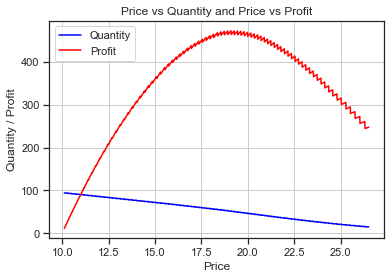

In [93]:
plt.plot(df_pred['price'].values, df_pred['quantity'].values, label='Quantity', color='blue', linestyle='-')
plt.plot(df_pred['price'].values, df_pred['profit'].values, label='Profit', color='red', linestyle='-')
# Add labels and title
plt.xlabel('Price')
plt.ylabel('Quantity / Profit')
plt.title('Price vs Quantity and Price vs Profit')

# Add grid lines
plt.grid(True)

# Add legend
plt.legend()

# Show the plot
plt.show();

In [94]:
ind = np.where(df_pred['profit'] == df_pred['profit'].max())[0][0]
df_pred.loc[[ind]]

,price,quantity,profit
897,19.09,52,472.68


Apparently, if we want to make the best profit, we should sell the BURGER at 19.76 with the expected quantity of BURGER sold is 49, when it's a non-holiday, not a schoolbreak, in the month of June and the day of Tuesday.

That's quantitatively. Of course, we need to also consider qualitative factors such as competitor analysis and customers' willingness to spend. If they are known, we can decide on what's the best BURGER price we can have.

# Conclusion

This project is aimed to create a price elasticity model using simple neural network. This is going to be useful for the burger joint to ensure they get the maximum profitability.